In [1]:
from __future__ import division

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
#from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
import numpy as np
 
from sklearn.datasets import load_boston
import seaborn as sns

In [2]:
train_ds = "mushroom_train.csv"
test_ds = "mushroom_test.csv"

In [3]:
data = pd.read_csv(train_ds)

## Data renaming
1. Replace '-' with '\_' to make label name work with pandas 
2. Replace ? with np.NaN to make life easy

In [5]:
data.rename(columns=lambda x: x.replace('-', '_'), inplace=True) # Rename labels to work
data = data.replace({'?': np.NaN}, regex=False);

## Missing value filter
Remove all feature having more than 70% missing data

In [6]:
data = data.dropna(thresh=0.7*len(data), axis=1)

## Identifying data types

In [7]:
data.head()
print data.dtypes

class                       object
cap_shape                   object
cap_surface                 object
cap_color                   object
bruises                     object
odor                        object
gill_attachment             object
gill_spacing                object
gill_size                   object
gill_color                  object
stalk_shape                 object
radius                       int64
stalk_surface_above_ring    object
stalk_surface_below_ring    object
stalk_color_above_ring      object
stalk_color_below_ring      object
veil_type                   object
veil_color                  object
weight                       int64
ring_number                 object
ring_type                   object
spore_print_color           object
population                  object
habitat                     object
dtype: object



This shows that except `radius` and `weight` all other variables are categorical 

# Data visualisation and analysis

In [9]:
X_vis = data.drop("class",axis=1)
y_vis = pd.get_dummies(data)['class_p']
data_vis = data.copy()

data_vis["class"][data_vis["class"] == "p"] = 1
data_vis["class"][data_vis["class"] == "e"] = 0
    
data_vis.head()

/home/suyash/app/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/suyash/app/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,weight,ring_number,ring_type,spore_print_color,population,habitat
0,1,f,s,e,f,s,f,c,n,b,...,p,w,p,w,38,o,e,w,v,l
1,1,x,y,w,t,p,f,c,n,k,...,w,w,p,w,43,o,p,n,v,u
2,0,f,s,n,t,n,f,c,b,e,...,e,e,p,w,37,t,e,w,c,w
3,1,x,s,e,f,y,f,c,n,b,...,p,w,p,w,82,o,e,w,v,l
4,0,x,s,w,t,l,f,c,b,n,...,w,w,p,w,36,o,p,n,s,m


## Visualisation

Currently categories are represented by alphabets. To visualize them they are first convereted to integer using following logic

In [10]:
data_mapped = data_vis.copy()
for col in data_vis.columns:
    if (col != "class"):
        col_unique = data[col].unique()
        col_dict = dict(zip(col_unique, range(len(col_unique))))
        data_mapped[col] = data_mapped[col].map(col_dict)

In [11]:
data_mapped.dtypes

class                       object
cap_shape                    int64
cap_surface                  int64
cap_color                    int64
bruises                      int64
odor                         int64
gill_attachment              int64
gill_spacing                 int64
gill_size                    int64
gill_color                   int64
stalk_shape                  int64
radius                       int64
stalk_surface_above_ring     int64
stalk_surface_below_ring     int64
stalk_color_above_ring       int64
stalk_color_below_ring       int64
veil_type                    int64
veil_color                   int64
weight                       int64
ring_number                  int64
ring_type                    int64
spore_print_color            int64
population                   int64
habitat                      int64
dtype: object

All datatypes are now converted to int64 this is evident in the head of `data_mapped`

In [13]:
print data_mapped.shape
data_mapped.head()

(5686, 24)


,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,weight,ring_number,ring_type,spore_print_color,population,habitat
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,0,0,0,1,...,1,0,0,0,1,0,1,1,0,1
2,0,0,0,2,1,2,0,0,1,2,...,2,1,0,0,2,1,0,0,1,2
3,1,1,0,0,0,3,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
4,0,1,0,1,1,4,0,0,1,3,...,1,0,0,0,4,0,1,1,2,3


### Filtering for data visualisation
Drop columns containing continous variables

In [14]:
# Deletes column containing continous variables
try:
    del data_mapped["radius"]
    del data_mapped["weight"]
except KeyError:
    print "Columns do not exists in the dataframe"

Convert each remaining categorical feature to percent for visualisation

In [15]:
print "Shape of dataframe: ", data_mapped.shape

# Runs thorough each element of each column to get highest categary mapping found
max_mapped_cat = int(max(data_mapped.max())+1)
print "Max number of categories are: ", max_mapped_cat

#plot_list = [[0] * len(data_mapped.columns)] * max_mapped_cat
plot_list = []
for i in range(max_mapped_cat):
    plot_list.append([0] * len(data_mapped.columns))
# Iterate through each element and count them
colId = 0
row_count = len(data_mapped.index)


for i in range(max_mapped_cat):
    colId = 0
    for col in data_mapped.columns:
        try:
            plot_list[i][colId] = ((data_mapped[col].value_counts())[i]*100)/row_count
        except KeyError:
            pass
        colId += 1
        #print colId

Shape of dataframe:  (5686, 22)
Max number of categories are:  12


Prepare plot for displaying features in stacked bar graph

In [17]:
N = len(data_mapped.columns)
ind = np.arange(N)
width = 0.5
p = []

# Generates list of random hex color string
def r():
    return random.randint(0,255)

plot_colors = [('#%02X%02X%02X' % (r(),r(),r())) for i in range(max_mapped_cat)]

bottom_list = [0]*len(plot_list[0])
for i in range(max_mapped_cat):
    p.append(plt.bar(ind, plot_list[i], width, color=plot_colors[i], bottom=bottom_list))
    #print len(plot_list[i])
    for k in range(len(plot_list[i])):
        bottom_list[k] += plot_list[i][k]

## Plot category percent of each categorical var

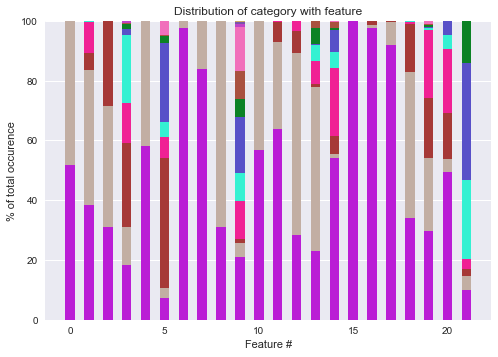

In [18]:
plt.rcParams["figure.figsize"] = [16, 8]
plt.ylabel('% of total occurence')
plt.xlabel('Feature #')
plt.title('Distribution of category with feature')

plt.show()

## Transforming categorical data
Convert all categorical data to dummy features

In [20]:
data = pd.get_dummies(data)
data.shape

(5686, 116)

Split test and train dataset using default configuration

In [21]:
X = data.drop("class_p",axis=1).drop("class_e", axis=1)
y = data['class_p']
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Training model
Uses Random forrest ensemble to train model

In [22]:
rf = RandomForestRegressor(n_estimators=10, verbose=True, n_jobs=-1)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=True, warm_start=False)

## Predictions
Predict using the model on test dataset

In [23]:
predictions = rf.predict(X_test)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


## Accuracy

Verify data types

In [24]:
predictions = predictions.astype(np.uint8, copy=False)
y_test_ndarray = y_test.values
print type(predictions)
print type(y_test_ndarray)

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


In [25]:
from sklearn.metrics import accuracy_score
print "Accuracy: " + str(accuracy_score(y_test.values, predictions)*100) + "%"

Accuracy: 99.929676512%
